In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.stats import linregress
import numpy as np
from scipy import stats

In [2]:
# Create a DataFrame with csv file
data_df = pd.read_csv('Resources/United_States_COVID-19.csv')
data_df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,03/11/2021,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN
1,12/01/2021,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree
2,01/02/2022,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN
3,11/22/2021,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree
4,05/30/2022,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN


In [3]:
# Create a copy of DataFrame with columns we need
reduced_data_df = data_df[["submission_date", "state", "tot_cases", "new_case","tot_death"]].copy()
reduced_data_df.head()

,submission_date,state,tot_cases,new_case,tot_death
0,03/11/2021,KS,297229,0,4851
1,12/01/2021,ND,163565,589,1907
2,01/02/2022,AS,11,0,0
3,11/22/2021,AL,841461,703,16377
4,05/30/2022,AK,251425,0,1252


In [4]:
# Changing data type of submission date to datetime
reduced_data_df["submission_date"] = reduced_data_df[['submission_date']].apply(pd.to_datetime)

In [5]:
# Sorting the data by ascending submission date
reduced_data_df = reduced_data_df.sort_values("submission_date", ascending = True)

In [6]:
# List of Regions 
West = ["WA", "OR", "CA", "NV", "ID", "MT", "WY", "UT", "CO", "AZ", "NM"]
Mid_West = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
North_East = ["ME", "NH", "VT", "MA", "CT", "RMI", "NY", "PA", "NJ"]
South = ["TX", "OK", "AR", "LA", "MS", "TN", "KY", "AL", "FL", "GA", "SC", "NC", "VA", "WV", "DC", "MD", "DE"]

reduced_data_df["Region"] = reduced_data_df["state"].apply(lambda x: "West" if x in West else
                                                          ("Mid_West" if x in Mid_West else
                                                          ("North_East" if x in North_East else
                                                          ("South" if x in South else np.nan))))
reduced_data_df

,submission_date,state,tot_cases,new_case,tot_death,Region
50494,2020-01-22,WA,0,0,0,West
32276,2020-01-22,WI,0,0,0,Mid_West
51294,2020-01-22,WV,0,0,0,South
8824,2020-01-22,UT,0,0,0,West
2152,2020-01-22,GA,0,0,0,South
...,...,...,...,...,...,...
37836,2022-10-18,NE,540345,956,4559,Mid_West
23106,2022-10-18,MD,1261834,689,15497,South
25286,2022-10-18,MO,1660094,0,21600,Mid_West
18065,2022-10-18,VI,23269,13,123,NaN


In [7]:

# Getting Month and Year 
reduced_data_df['Year'] = reduced_data_df['submission_date'].dt.year
reduced_data_df['Month'] = reduced_data_df['submission_date'].dt.month


# Getting Year-Month
reduced_data_df['yyyy-mm'] = reduced_data_df['submission_date'].dt.strftime('%Y-%m')

reduced_data_df.head()

,submission_date,state,tot_cases,new_case,tot_death,Region,Year,Month,yyyy-mm
50494,2020-01-22,WA,0,0,0,West,2020,1,2020-01
32276,2020-01-22,WI,0,0,0,Mid_West,2020,1,2020-01
51294,2020-01-22,WV,0,0,0,South,2020,1,2020-01
8824,2020-01-22,UT,0,0,0,West,2020,1,2020-01
2152,2020-01-22,GA,0,0,0,South,2020,1,2020-01


In [8]:
# Dividing each region into sepereate DataFrames
West_data = reduced_data_df.loc[(reduced_data_df["Region"] == "West")]
Mid_West_data = reduced_data_df.loc[(reduced_data_df["Region"] == "Mid_West")]
South_data = reduced_data_df.loc[(reduced_data_df["Region"] == "South")]
North_East_data = reduced_data_df.loc[(reduced_data_df["Region"] == "North_East")]

Mid_West_data.tail()

,submission_date,state,tot_cases,new_case,tot_death,Region,Year,Month,yyyy-mm
33904,2022-10-18,MI,2874009,12414,39092,Mid_West,2022,10,2022-10
36971,2022-10-18,IL,3789532,1333,39867,Mid_West,2022,10,2022-10
37554,2022-10-18,WI,1884206,1156,15374,Mid_West,2022,10,2022-10
37836,2022-10-18,NE,540345,956,4559,Mid_West,2022,10,2022-10
25286,2022-10-18,MO,1660094,0,21600,Mid_West,2022,10,2022-10


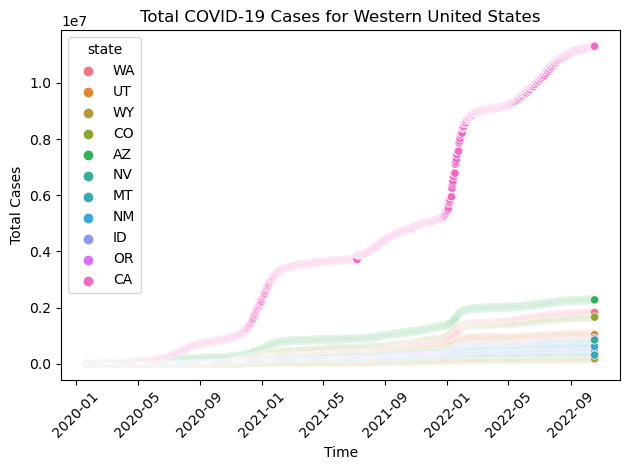

In [9]:
import seaborn as sns

# Western Region Total Case Timeline 
date = West_data["submission_date"]
value = West_data["tot_cases"]
state = West_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=West_data["tot_cases"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Total COVID-19 Cases for Western United States")
plt.tight_layout()
plt.savefig('Western_total_cases.png')

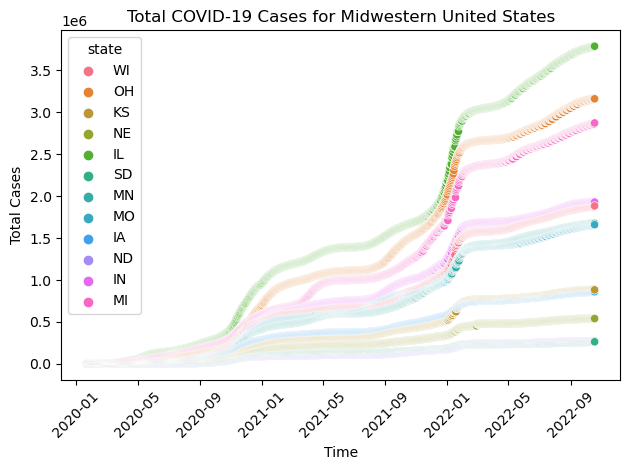

In [10]:
# Midwestern Region Total Case Timeline 
date = Mid_West_data["submission_date"]
value = Mid_West_data["tot_cases"]
state = Mid_West_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=Mid_West_data["tot_cases"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Total COVID-19 Cases for Midwestern United States")
plt.tight_layout()
plt.savefig('Mid_Western_total_cases.png')

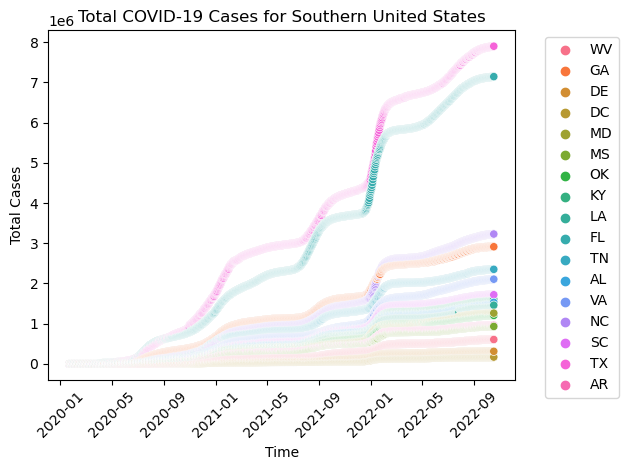

In [11]:
# Southern Region Total Case Timeline 
date = South_data["submission_date"]
value = South_data["tot_cases"]
state = South_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=South_data["tot_cases"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Total COVID-19 Cases for Southern United States")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('Southern_total_cases.png')

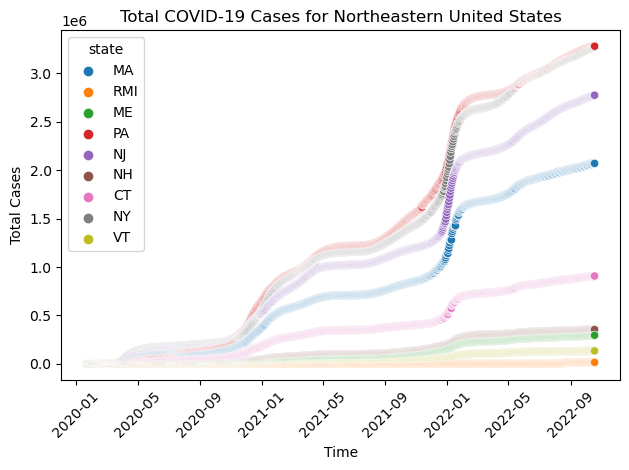

In [12]:
# Northeastern Region Total Case Timeline 
date = North_East_data["submission_date"]
value = North_East_data["tot_cases"]
state = North_East_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=North_East_data["tot_cases"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Total COVID-19 Cases for Northeastern United States")
plt.tight_layout()
plt.savefig('Northeastern_total_cases.png')

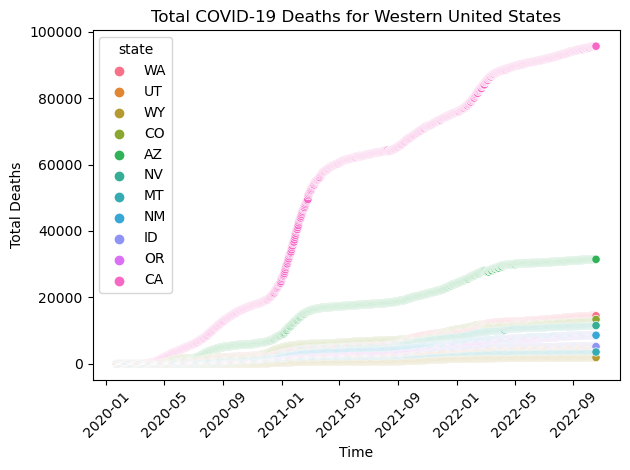

In [13]:
# Western Region Total Deaths Timeline 
date = West_data["submission_date"]
value = West_data["tot_death"]
state = West_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=West_data["tot_death"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Deaths")
plt.title("Total COVID-19 Deaths for Western United States")
plt.tight_layout()
plt.savefig('Western_total_deaths.png')

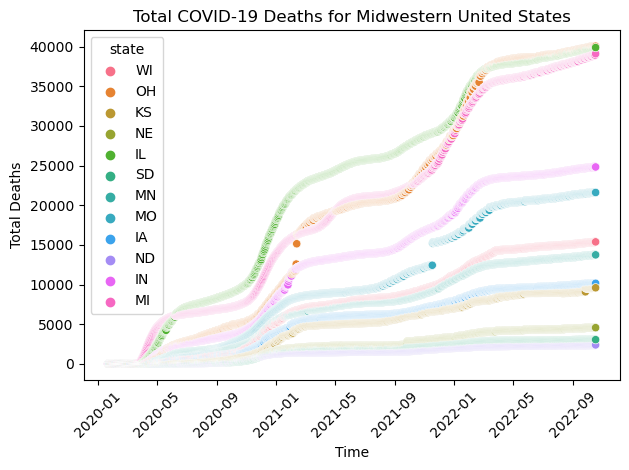

In [14]:
# Midwestern Region Total Deaths Timeline 
date = Mid_West_data["submission_date"]
value = Mid_West_data["tot_death"]
state = Mid_West_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=Mid_West_data["tot_death"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Deaths")
plt.title("Total COVID-19 Deaths for Midwestern United States")
plt.tight_layout()
plt.savefig('Mid_Western_total_deaths.png')

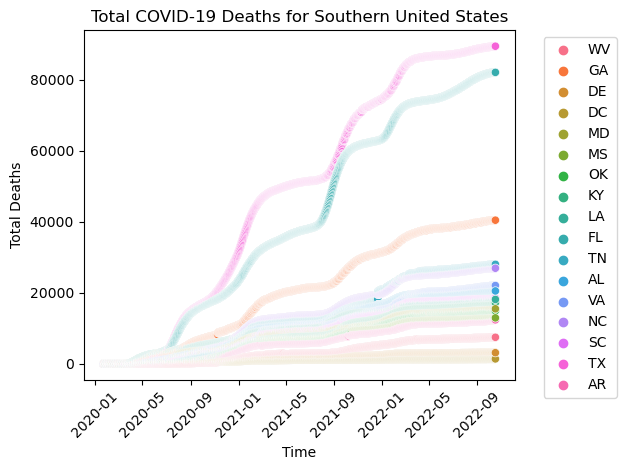

In [15]:
# Southern Region Total Death Timeline 
date = South_data["submission_date"]
value = South_data["tot_death"]
state = South_data["state"]

# Plot
g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=South_data["tot_death"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Deaths")
plt.title("Total COVID-19 Deaths for Southern United States")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig('Southern_total_deaths.png')

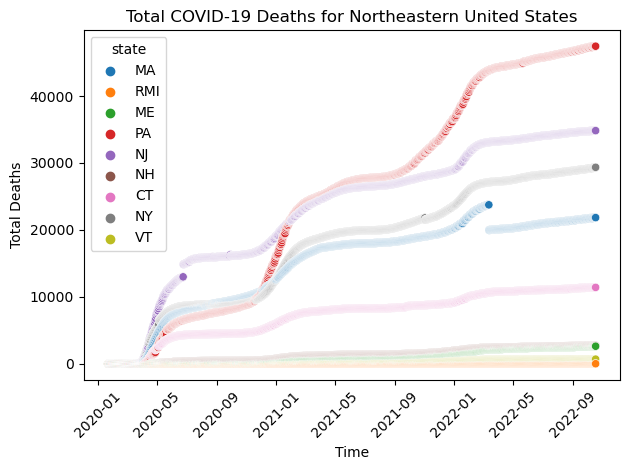

In [16]:
# Western Region Total Case Timeline 
date = North_East_data["submission_date"]
value = North_East_data["tot_death"]
state = North_East_data["state"]

g =sns.scatterplot(x= date, y=value,
              hue= state,
              data=North_East_data["tot_cases"]);
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Total Deaths")
plt.title("Total COVID-19 Deaths for Northeastern United States")
plt.tight_layout()
plt.savefig('Northeastern_total_deaths.png')